In [1]:
!pip install -q kaggle

In [7]:
!mkdir kaggle

In [8]:
!cp kaggle.json ./kaggle/

In [9]:
!chmod 600 ./kaggle/kaggle.json

In [10]:
!kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-gaussian-filtered

Dataset URL: https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-gaussian-filtered
License(s): CC0-1.0
100% 426M/427M [00:14<00:00, 33.4MB/s]
100% 427M/427M [00:14<00:00, 30.8MB/s]


In [11]:
import zipfile
import os

def unzip_folder(zip_file, extract_to):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Example usage:
zip_file = 'diabetic-retinopathy-224x224-gaussian-filtered.zip'  # Specify the path to your zip file
extract_to = './data'  # Specify the directory where you want to extract the files
unzip_folder(zip_file, extract_to)

In [31]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import PIL
import plotly
import plotly.express as px
import gc
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,Input,ZeroPadding2D,BatchNormalization,Activation
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from tensorflow.keras.layers.experimental import preprocessing

from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

In [23]:
path = '/content/data/gaussian_filtered_images/gaussian_filtered_images'
No_DR_Img = os.listdir(path + '/No_DR/')
Mild_Img = os.listdir(path + '/Mild/')
Moderate_Img = os.listdir(path + '/Moderate/')
Proliferate_DR_Img = os.listdir(path + '/Proliferate_DR/')
Severe_Img = os.listdir(path + '/Severe/')

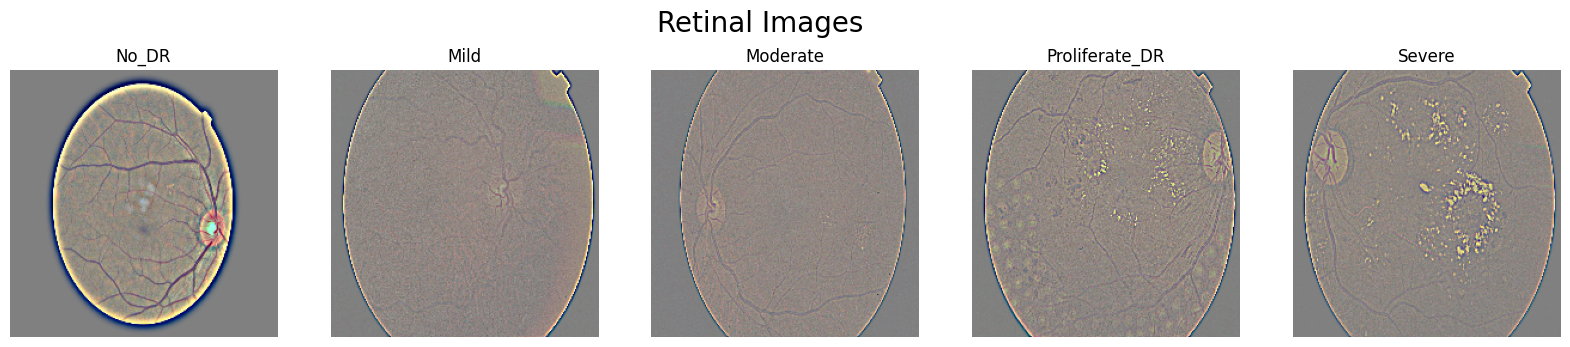

In [24]:
# Viewing the dataset
fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # Adjust the number of subplots according to the number of folders

# Iterate over each folder and print one image from each
for i, (folder, folder_name) in enumerate(zip([No_DR_Img, Mild_Img, Moderate_Img, Proliferate_DR_Img, Severe_Img], ['No_DR', 'Mild', 'Moderate', 'Proliferate_DR', 'Severe'])):
    img_path = os.path.join(path, folder_name, folder[0])  # Selecting the first image from each folder
    img = cv2.imread(img_path)
    axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i].set_title(folder_name)
    axes[i].axis('off')

plt.suptitle("Retinal Images", fontsize=20)
plt.show()

In [25]:
Classes = {'No_DR':0, 'Mild':1, 'Moderate':2, 'Severe':3, 'Proliferate_DR':4}

In [28]:
#Normalizing pixel values
X = []
y = []
desired_size = (128, 128)

for i in Classes:
    folder_path = '/content/data/gaussian_filtered_images/gaussian_filtered_images/' +i
    for j in os.listdir(folder_path):
        img = cv2.imread(folder_path+'/'+j)
        img = cv2.resize(img, desired_size)
        # normalize values
        img = img / 255  #-->Apply normalization because we want pixel values to be scaled to the range 0-1
        X.append(img)
        y.append(Classes[i])

In [29]:
X = np.array(X)
y = np.array(y)

X.shape, y.shape

((3662, 128, 128, 3), (3662,))

In [32]:
#Class division

Class_series=pd.Series(y)
lis=["No_DR","Mild","Moderate","Severe","Proliferate_DR"]
DR_or_not = Class_series.value_counts().tolist()
values = [DR_or_not[0], DR_or_not[1], DR_or_not[2], DR_or_not[3], DR_or_not[4]]
fig = px.pie(values=Class_series.value_counts(), names=lis , width=800, height=400, color_discrete_sequence=["skyblue","black","pink","purple","blue"]
             ,title="percentage among the different Severities of DR")
fig.show()

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Apply data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Reshape X to have the correct dimensions
X = X.reshape(X.shape[0], 128, 128, 3)

datagen.fit(X)

In [34]:
from imblearn.over_sampling import SMOTE
# Using SMOTE to oversample the minority class(Edema) to avoid class imbalance
sm = SMOTE(random_state = 2)
X, y = sm.fit_resample(X.reshape(X.shape[0], -1), y.ravel())

In [36]:
Class_series=pd.Series(y)
lis=["No_DR","Mild","Moderate","Severe","Proliferate_DR"]
DR_or_not = Class_series.value_counts().tolist()
values = [DR_or_not[0], DR_or_not[1], DR_or_not[2], DR_or_not[3], DR_or_not[4]]
fig = px.pie(values=Class_series.value_counts(), names=lis , width=800, height=400, color_discrete_sequence=["skyblue","black","pink","purple","blue"]
             ,title="percentage among the different Severities of DR")
fig.show()

In [37]:
X[0].shape

(49152,)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=32, stratify=y)

In [39]:
X_train.shape

(7220, 49152)

In [40]:
X_test.shape

(1805, 49152)

In [41]:
# Reshape the arrays
X_train = X_train.reshape((-1, 128, 128, 3))
X_test = X_test.reshape((-1, 128, 128, 3))

In [42]:
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (7220, 128, 128, 3)
Testing data shape: (1805, 128, 128, 3)


In [43]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

In [44]:
resnet18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 43.1MB/s]


In [45]:
for param in resnet18.parameters():
    param.requires_grad = False

In [ ]:
print(resnet18)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

In [48]:
device

device(type='cuda')

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001)

In [50]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Random resized crop
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    transforms.RandomRotation(degrees=20),  # Random rotation
    transforms.ToTensor(),  # Convert image to tensor
])

In [61]:
num_epochs = 20

In [53]:
import torch.nn.init as init

# Initialize the model with Glorot (Xavier) uniform weights
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight.data)

# Apply weight initialization to the model
resnet18.apply(weights_init)

# Define the optimizer with a learning rate of 0.001
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001)

# Define the batch size
batch_size = 16

# Assuming X_test_tensor is your test input data tensor
X_test_tensor = torch.tensor(X_test.transpose((0, 3, 1, 2)), dtype=torch.float32).cuda()  # Convert and rearrange dimensions, then convert to float32 and move to GPU

# Assuming y_test_tensor is your test target tensor
y_test_tensor = torch.tensor(y_test, dtype=torch.long).cuda()  # Convert y_test to tensor of type long and move to GPU

# Create TensorDataset for test data
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [58]:
import torch.nn.init as init

# Initialize the model with Glorot (Xavier) uniform weights
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight.data)

# Apply weight initialization to the model
resnet18.apply(weights_init)

# Define the optimizer with a learning rate of 0.001
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001)

# Define the batch size
batch_size = 16

# Assuming X_train_tensor is your train input data tensor
X_train_tensor = torch.tensor(X_train.transpose((0, 3, 1, 2)), dtype=torch.float32).cuda()  # Convert and rearrange dimensions, then convert to float32 and move to GPU

# Assuming y_train_tensor is your train target tensor
y_train_tensor = torch.tensor(y_train, dtype=torch.long).cuda()  # Convert y_train to tensor of type long and move to GPU

# Create TensorDataset for train data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Create DataLoader for train data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

In [59]:
# Check the structure of the first sample in your dataset
sample = train_dataset[0]
print(len(sample))  # This should output 2

2


In [60]:
best_accuracy = 0.0
best_loss = float('inf')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
from torch.nn.init import xavier_uniform_, kaiming_normal_
import itertools

# Define hyperparameters
learning_rates = [0.001]
optimizers = [optim.Adam]
weight_initializers = [xavier_uniform_, kaiming_normal_]
batch_sizes = [16, 32, 64]

# Initialize a dictionary to store results
results = {}

# Define the number of epochs
num_epochs = 45  # Adjust as needed

# Iterate over all combinations of hyperparameters
for lr, optimizer, weight_initializer, batch_size in itertools.product(learning_rates, optimizers, weight_initializers, batch_sizes):
    # Initialize ResNet18 model
    resnet18 = models.resnet18(pretrained=True)

    # Freeze model parameters
    for param in resnet18.parameters():
        param.requires_grad = False

    # Modify the last fully connected layer
    num_ftrs = resnet18.fc.in_features
    resnet18.fc = nn.Linear(num_ftrs, 5)  # Assuming 5 classes

   # Initialize the model with Glorot (Xavier) uniform weights
    def weights_init(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            if hasattr(m, 'weight'):
                init.xavier_uniform_(m.weight.data)


    # Move the model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    resnet18.to(device)

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Define optimizer
    optimizer_instance = optimizer(resnet18.parameters(), lr=lr)

    # Define train loader with current batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Define test loader
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize a dictionary to store training history
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'test_loss': [],
        'test_accuracy': []
    }

    # Training loop
    for epoch in range(num_epochs):
        # Set the model to training mode
        resnet18.train()

        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.float().to(device), labels.to(device)

            # Zero the gradients
            optimizer_instance.zero_grad()

            # Forward pass
            outputs = resnet18(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer_instance.step()

            # Update statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        # Calculate training loss and accuracy
        epoch_loss = running_loss / total_samples
        epoch_acc = correct_predictions / total_samples

        # Append the training loss and accuracy to the history dictionary
        history['train_loss'].append(epoch_loss)
        history['train_accuracy'].append(epoch_acc)

        # After each epoch, evaluate the model on the test set
        resnet18.eval()
        test_correct_predictions = 0
        test_total_samples = 0
        test_loss = 0.0

        # Disable gradient computation for evaluation
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = resnet18(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                test_correct_predictions += (predicted == labels).sum().item()
                test_total_samples += labels.size(0)

        # Calculate test accuracy
        test_accuracy = test_correct_predictions / test_total_samples

        # Calculate average test loss
        test_loss /= test_total_samples

        # Append test loss and accuracy to the history dictionary
        history['test_loss'].append(test_loss)
        history['test_accuracy'].append(test_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Training Loss: {epoch_loss:.4f}, '
              f'Training Accuracy: {epoch_acc:.4f}, '
              f'Test Loss: {test_loss:.4f}, '
              f'Test Accuracy: {test_accuracy:.4f}')

    # Store results for this configuration
    results[(lr, optimizer.__name__, weight_initializer.__name__, batch_size)] = history

Epoch [1/45], Training Loss: 1.1155, Training Accuracy: 0.5439, Test Loss: 0.9519, Test Accuracy: 0.6266
Epoch [2/45], Training Loss: 0.9694, Training Accuracy: 0.6141, Test Loss: 0.9813, Test Accuracy: 0.6211
Epoch [3/45], Training Loss: 0.9253, Training Accuracy: 0.6283, Test Loss: 0.8648, Test Accuracy: 0.6554
Epoch [4/45], Training Loss: 0.9026, Training Accuracy: 0.6438, Test Loss: 0.8451, Test Accuracy: 0.6720
Epoch [5/45], Training Loss: 0.8687, Training Accuracy: 0.6571, Test Loss: 0.8334, Test Accuracy: 0.6820
Epoch [6/45], Training Loss: 0.8678, Training Accuracy: 0.6548, Test Loss: 0.8422, Test Accuracy: 0.6709
Epoch [7/45], Training Loss: 0.8549, Training Accuracy: 0.6690, Test Loss: 0.8542, Test Accuracy: 0.6648
Epoch [8/45], Training Loss: 0.8549, Training Accuracy: 0.6679, Test Loss: 0.8473, Test Accuracy: 0.6715
Epoch [9/45], Training Loss: 0.8409, Training Accuracy: 0.6752, Test Loss: 0.8011, Test Accuracy: 0.7075
Epoch [10/45], Training Loss: 0.8315, Training Accuracy

In [ ]:
best_accuracy = 0.0
best_config = None

for config, history in results.items():
    test_accuracy = history['test_accuracy'][-1]  # Get the test accuracy from the last epoch

    # Check if the current configuration has higher test accuracy than the previous best
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_config = config

print("Best configuration:")
print("Learning Rate:", best_config[0])
print("Optimizer:", best_config[1])
print("Weight Initializer:", best_config[2])
print("Batch Size:", best_config[3])
print("Test Accuracy:", best_accuracy)

In [ ]:
best_history = results[best_config]

# Extract the training and test metrics
best_train_loss = best_history['train_loss'][-1]
best_train_accuracy = best_history['train_accuracy'][-1]
best_test_loss = best_history['test_loss'][-1]
best_test_accuracy = best_history['test_accuracy'][-1]

# Print the metrics
print("Best Configuration Metrics:")
print("Training Loss:", best_train_loss)
print("Training Accuracy:", best_train_accuracy)
print("Test Loss:", best_test_loss)
print("Test Accuracy:", best_test_accuracy)

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    train_loss = history['train_loss']
    test_loss = history['test_loss']
    train_accuracy = history['train_accuracy']
    test_accuracy = history['test_accuracy']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(test_loss, label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(test_accuracy, label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Call the plot_metrics function with the history of the best configuration
plot_metrics(best_history)

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image

def predict_image_class(img_path, model, class_labels):
    # Load the image
    img = Image.open(img_path)

    # Define transformations to apply to the image
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Resize to match the input size of your model
        transforms.ToTensor(),           # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet mean and std
    ])

    # Apply transformations to the image
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension

    # Move the tensor to the appropriate device (e.g., GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img_tensor = img_tensor.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Perform inference
    with torch.no_grad():
        outputs = model(img_tensor)

    # Convert the output probabilities to predicted class label
    predicted_class_index = torch.argmax(outputs).item()

    # Map predicted class index to class label
    predicted_class_label = class_labels[predicted_class_index]

    return predicted_class_label

# Example usage:
# Assuming `resnet18` is your pre-trained model and `class_labels` is a list of class labels
img_path = '/content/data/gaussian_filtered_images/gaussian_filtered_images/Moderate/000c1434d8d7.png'
predicted_label = predict_image_class(img_path, resnet18, ['Mild', 'Moderate','No', 'Proliferate', 'Severe'])
print("Predicted class label:", predicted_label)

In [ ]:
# Save the model
torch.save(resnet18.state_dict(), 'model.pth')

# Print the path to the saved model
print("Model saved at:", 'model2.pth')